In [14]:
# Loading the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import detrend, find_peaks, welch, savgol_filter
import cv2

In [2]:
# Step 1: Loading the heart bit signal data

data = pd.read_csv("heart_beat_signal.csv", header = None, names= ['Time', 'Amplitude'])

print(data.head())

       Time  Amplitude
0  0.033367     32.808
1  0.066733     32.793
2  0.100100     33.042
3  0.133470     32.232
4  0.166830     29.150


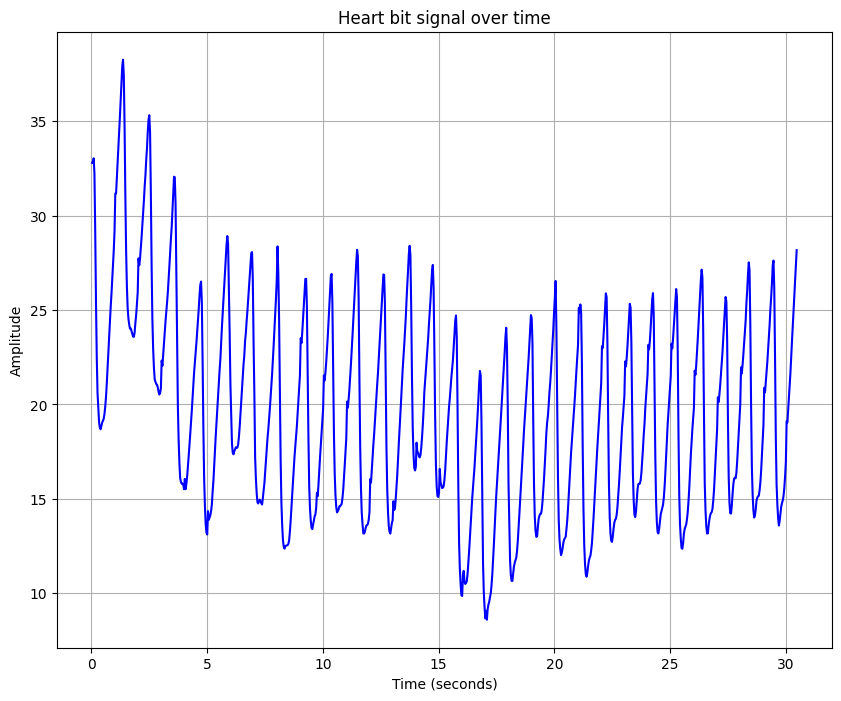

In [3]:
# Visualization of the heart bit signal

plt.figure(figsize=(10,8))
plt.plot(data['Time'], data['Amplitude'], color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Heart bit signal over time')
plt.grid(True)
plt.show()

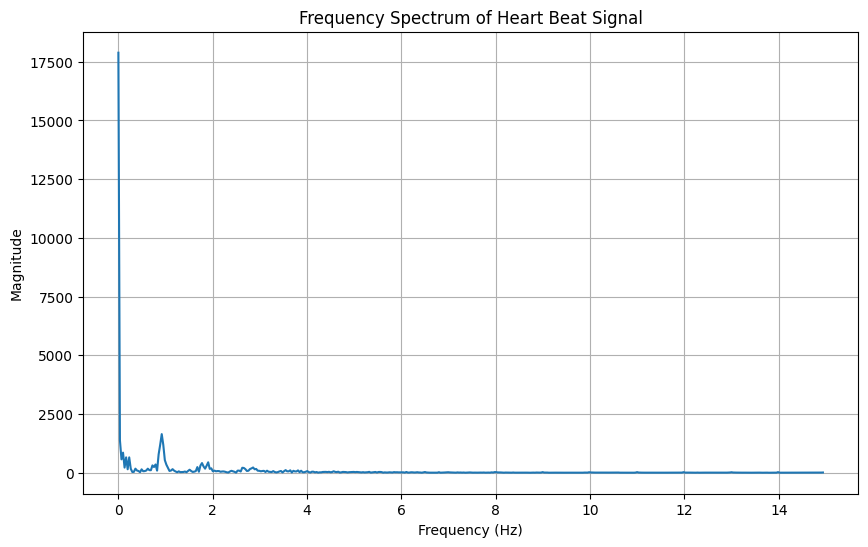

In [4]:
#  Step 2.1: Visualizing Signal Frequency Content using FFT to have an idea of how to select the cutt-off frequency

# Compute the FFT of the original signal
fft_signal = np.fft.fft(data['Amplitude'])
fft_freq = np.fft.fftfreq(len(data['Amplitude']), d=(data['Time'][1] - data['Time'][0]))

# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_signal)[:len(fft_signal)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Heart Beat Signal')
plt.grid(True)
plt.show()

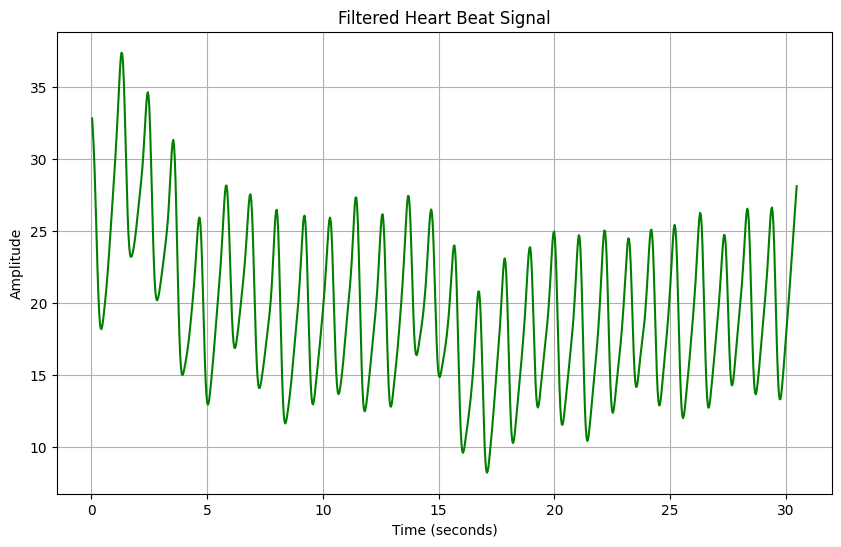

In [5]:

# Step 2: Signal Processing and Heart Rate Calculation

# Preprocessing Steps:
# It's important to preprocess the signal to enhance its quality and remove noise that might affect the accuracy of heart rate calculation.

# Step 2.1: Preprocessing - Noise Removal and Filtering

# Apply a low-pass filter to remove high-frequency noise
def lowpass_filter(signal, cutoff_freq, fs):
    b, a = scipy.signal.butter(4, cutoff_freq / (fs / 2), 'low')
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return filtered_signal

# Define parameters for the low-pass filter
cutoff_frequency = 2.5 
sampling_frequency = 1 / (data['Time'][1] - data['Time'][0])  # Calculate sampling frequency from time difference

# Apply low-pass filter to the signal
filtered_signal = lowpass_filter(data['Amplitude'], cutoff_frequency, sampling_frequency)

# Step 2.2: Visualization of the Filtered Signal
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], filtered_signal, color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Filtered Heart Beat Signal')
plt.grid(True)
plt.show()


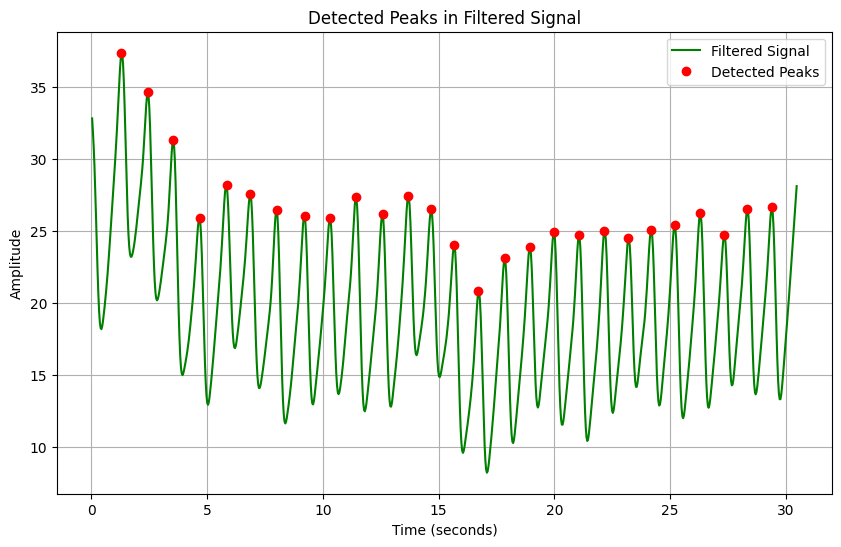

In [6]:

# Step 3: Heart Rate Detection Algorithm - Peak Detection

# Define a function for peak detection
def detect_peaks(signal, threshold):
    peaks = []
    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1] and signal[i] > threshold:
            peaks.append(i)
    return peaks

# Step 3.1: Peak Detection
# Set a threshold for peak detection
threshold = np.mean(filtered_signal) 

# Detect peaks in the filtered signal
peaks_indices = detect_peaks(filtered_signal, threshold)

# Step 3.2: Visualization of Detected Peaks
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], filtered_signal, color='green', label='Filtered Signal')
plt.plot(data['Time'][peaks_indices], filtered_signal[peaks_indices], 'ro', label='Detected Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Detected Peaks in Filtered Signal')
plt.legend()
plt.grid(True)
plt.show()


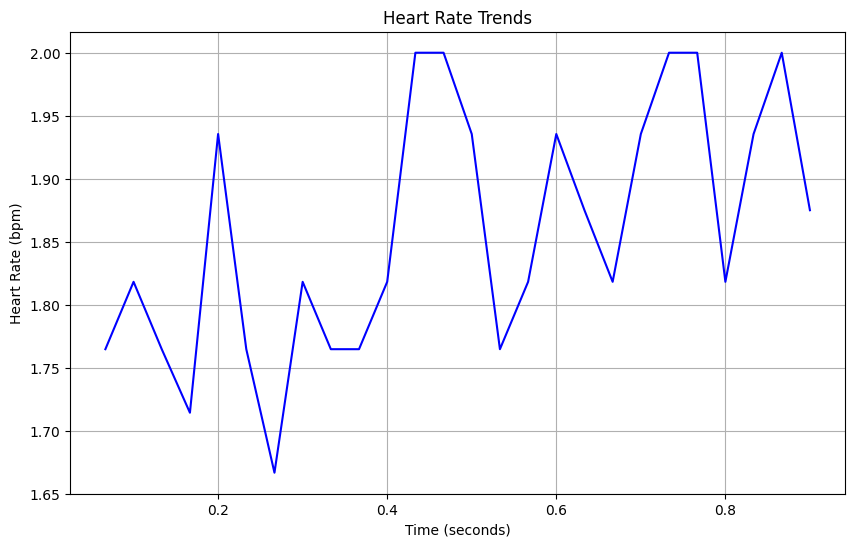

In [7]:
# Step 4: Calculate Inter-Beat Intervals (IBIs)
ibis = np.diff(peaks_indices)

# Step 5: Convert IBIs to Heart Rate
heart_rate = 60 / ibis

# Adjusting the time array to match the length of heart_rate
time_slice = data['Time'][1:len(heart_rate)+1]

# Step 6: Visualize Heart Rate Trends
plt.figure(figsize=(10, 6))
plt.plot(time_slice, heart_rate, color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate Trends')
plt.grid(True)
plt.show()


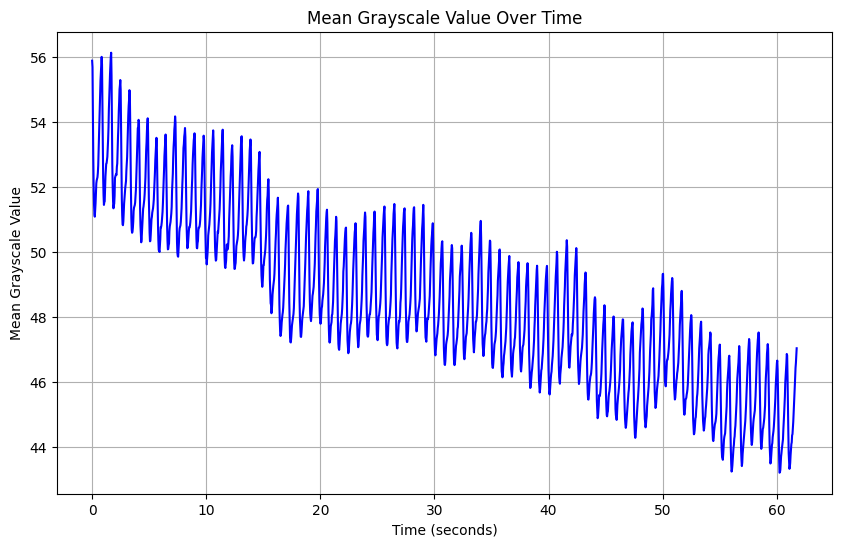

In [12]:
def load_video(video_path):
    # Load the video
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        exit()

    return cap

def process_frames(cap):
    # Get the total number of frames and frame rate
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the time array
    time_array = np.arange(0, num_frames / fps, 1 / fps)

    # Initialize an array to store mean grayscale values
    mean_grayscale_values = []

    # Iterate through each frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply noise reduction (Gaussian blur)
        blurred_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)

        # Calculate the mean grayscale value
        mean_grayscale_value = np.mean(blurred_frame)
        mean_grayscale_values.append(mean_grayscale_value)

    # Release the video capture object
    cap.release()

    return time_array, mean_grayscale_values

def plot_results(time_array, mean_grayscale_values):
    # Plot the mean grayscale values over time
    plt.figure(figsize=(10, 6))
    plt.plot(time_array[:len(mean_grayscale_values)], mean_grayscale_values, color='blue')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Mean Grayscale Value')
    plt.grid(True)
    plt.title('Mean Grayscale Value Over Time')

# Use the functions
cap = load_video('video_of_finger.MOV')
time_array, mean_grayscale_values = process_frames(cap)
plot_results(time_array, mean_grayscale_values)


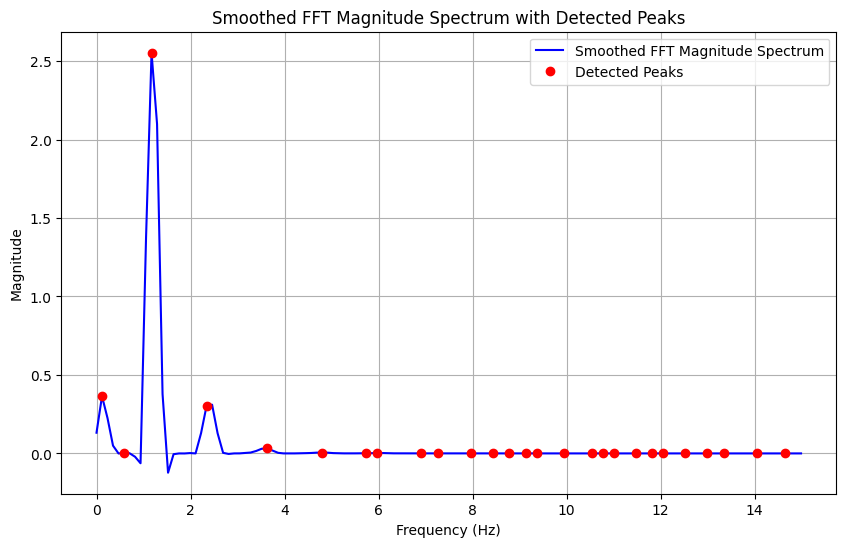

Estimated heart rate (FFT method): 70.26128362155016 BPM


In [16]:
def calculate_heart_rate_fft(mean_grayscale_values, fps, peak_distance=None):

    # Pre-processing
    detrended_values = detrend(mean_grayscale_values)
    normalized_values = (detrended_values - np.mean(detrended_values)) / np.std(detrended_values)

    # Apply Fast Fourier Transform (FFT)
    frequencies, magnitudes = welch(normalized_values, fs=fps)

    # Find peaks in the FFT magnitude spectrum
    peaks_indices, _ = find_peaks(magnitudes, distance=peak_distance)

    # Post-processing
    smoothed_magnitudes = savgol_filter(magnitudes, window_length=5, polyorder=3)  
    peak_freq_index = peaks_indices[np.argmax(smoothed_magnitudes[peaks_indices])]
    peak_freq = frequencies[peak_freq_index]

    # Convert the frequency to beats per minute (BPM)
    heart_rate = peak_freq * 60

    # Plot the FFT magnitude spectrum with detected peaks
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, smoothed_magnitudes, color='blue', label='Smoothed FFT Magnitude Spectrum')
    plt.plot(frequencies[peaks_indices], smoothed_magnitudes[peaks_indices], 'ro', label='Detected Peaks')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Smoothed FFT Magnitude Spectrum with Detected Peaks')
    plt.legend()
    plt.grid(True)
    plt.show()

    return heart_rate

# Function call
heart_rate_fft = calculate_heart_rate_fft(mean_grayscale_values, fps, peak_distance=None)
print("Estimated heart rate (FFT method):", heart_rate_fft, "BPM")